In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import torch
import torchaudio
import torchaudio.functional as F
import librosa
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from IPython.display import Audio, display

In [2]:
def load_audio(file_path, sr=None):
    try:
        audio_data, sampling_rate = librosa.load(file_path, sr=sr)
        return audio_data, sampling_rate
    except Exception as e:
        print(f"Error reading audio file: {e}")
        return None, None


def downsample_audio(audio, original_sr, target_sr):
    return librosa.resample(audio, orig_sr=original_sr, target_sr=target_sr)


def audio_to_melspectrogram(audio, sampling_rate, hop_length=256, n_fft=2048):
    spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=sampling_rate, hop_length=hop_length, n_fft=n_fft
    )
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram


def cut_random_segment_repeat(audio, segment_size):
    original_size = len(audio)

    if segment_size <= original_size:
        start_index = np.random.randint(0, original_size - segment_size + 1)
        cut_segment = audio[start_index : start_index + segment_size]
    else:
        repeat_factor = segment_size // original_size
        repeated_audio = np.tile(audio, repeat_factor)
        cut_segment = repeated_audio[:segment_size]

    return cut_segment


def cut_random_segment_zeros(audio, segment_size):
    original_size = len(audio)

    if segment_size <= original_size:
        start_index = np.random.randint(0, original_size - segment_size + 1)
        cut_segment = audio[start_index : start_index + segment_size]
    else:
        pad_size = segment_size - original_size
        repeated_audio = np.pad(audio, (0, pad_size), mode="constant")
        cut_segment = repeated_audio[:segment_size]

    return cut_segment


def cut_random_with_repeat(audio, segment_size):
    max_start_time = max(0, len(audio) - segment_size - 1)
    start_time = np.random.randint(0, max_start_time)
    return audio[start_time : (start_time + segment_size)]


def show_melspectrogram(
    spectrogram, sampling_rate, title="log-frequency power spectrogram"
):
    librosa.display.specshow(spectrogram, x_axis="time", y_axis="mel", sr=sampling_rate)
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.show()


def show_signal(audio):
    plt.plot(audio)
    plt.title("Signal")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()


def show_and_play_signal(audio, sample_rate):
    plt.plot(audio)
    plt.title("Signal")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()
    display(Audio(audio, rate=sample_rate))


def read_as_melspectrogram(file_path):
    audio, sampling_rate = load_audio(file_path)
    spectrogram = audio_to_melspectrogram(audio, sampling_rate)
    return spectrogram


def apply_effect(waveform, sample_rate, effect):
    effector = torchaudio.io.AudioEffector(effect=effect)
    return effector.apply(waveform, sample_rate)

In [3]:
from torchaudio.utils import download_asset


SAMPLE_WAV = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav")
SAMPLE_RIR = download_asset(
    "tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav"
)
SAMPLE_SPEECH = download_asset(
    "tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav"
)
SAMPLE_NOISE = download_asset(
    "tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav"
)

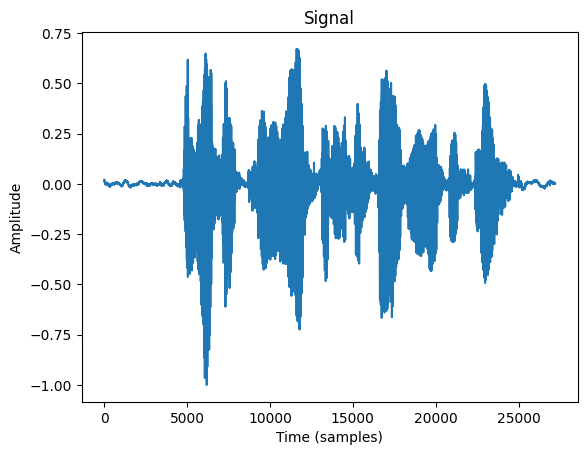

In [4]:
waveform, sample_rate = load_audio(SAMPLE_SPEECH)
show_and_play_signal(waveform, sample_rate)

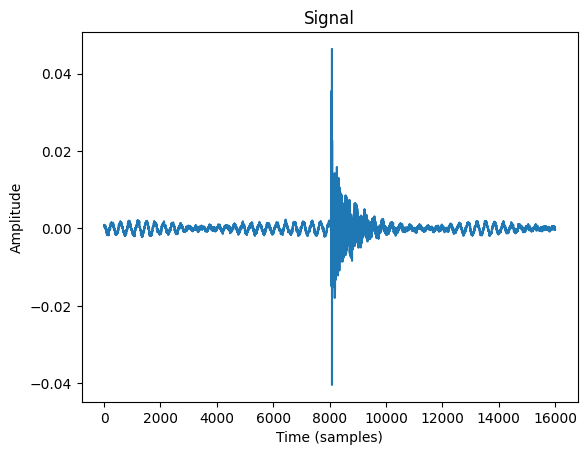

In [5]:
rir_raw, sample_rate = load_audio(SAMPLE_RIR)
show_and_play_signal(rir_raw, sample_rate)

In [6]:
rir = rir_raw[int(sample_rate * 1.01) : int(sample_rate * 1.3)]
rir = rir / np.linalg.norm(rir, ord=2)

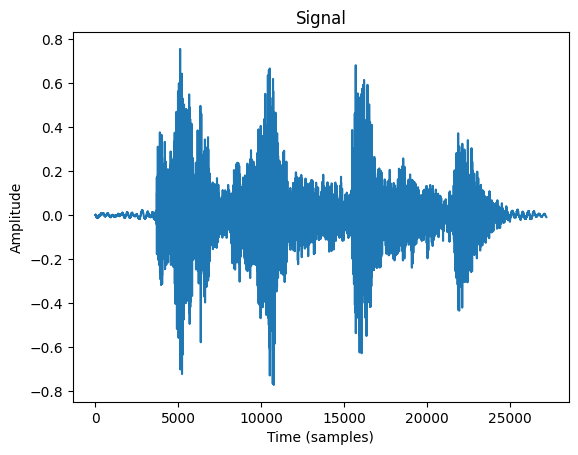

In [7]:
waveform_rir = np.convolve(waveform, rir, mode="same")
show_and_play_signal(waveform_rir, sample_rate)

In [8]:
from torchaudio_augmentations import RandomRIR


aug = RandomRIR("bank/rir_8k.pkl")

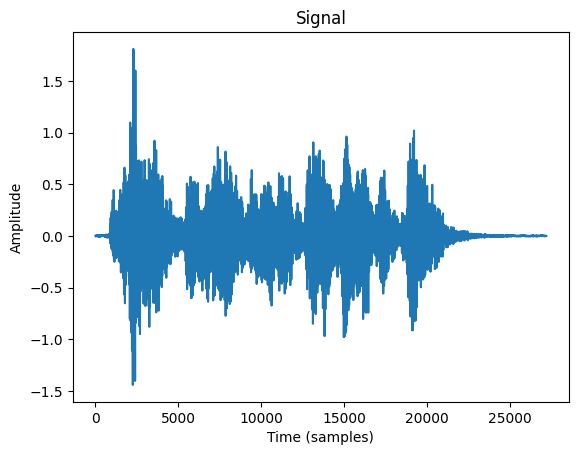

In [9]:
waveform_rir = aug(waveform)
show_and_play_signal(waveform_rir, sample_rate)

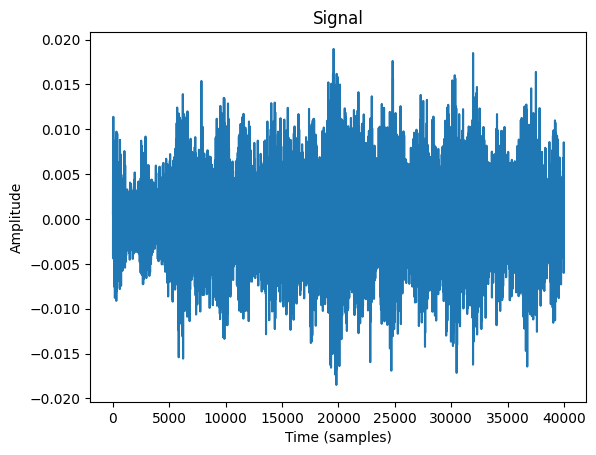

In [10]:
noise, sample_rate = load_audio(SAMPLE_NOISE)
show_and_play_signal(noise, sample_rate)

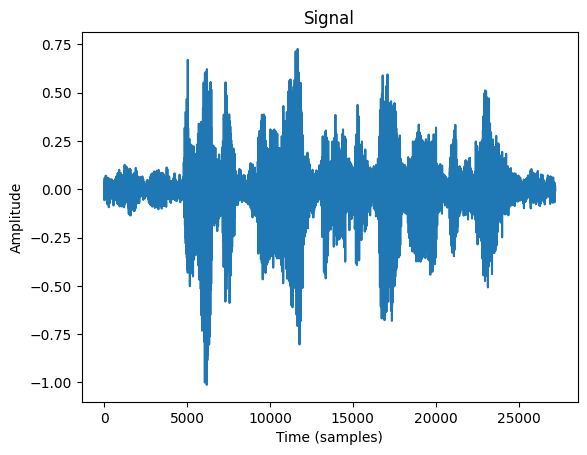

In [11]:
noise = cut_random_segment_repeat(noise, waveform.shape[0])

noise_t = torch.from_numpy(noise).unsqueeze(dim=0)
waveform_t = torch.from_numpy(waveform).unsqueeze(dim=0)
snr_dbs = torch.tensor([10])

noisy_speeches_t = F.add_noise(waveform_t, noise_t, snr_dbs)
noisy_speeches = noisy_speeches_t.squeeze().numpy()
show_and_play_signal(noisy_speeches, sample_rate)

In [44]:
from torchaudio_augmentations import RandomBackgroundNoise


noiser = RandomBackgroundNoise(
    noise_root="/media/klig/disk/datasets/arabic-natural-audio",
    sample_rate=8000,
    segment_size=waveform.shape[-1],
    bank_size=4,
    snr_dbs_range=[20, 30],
)

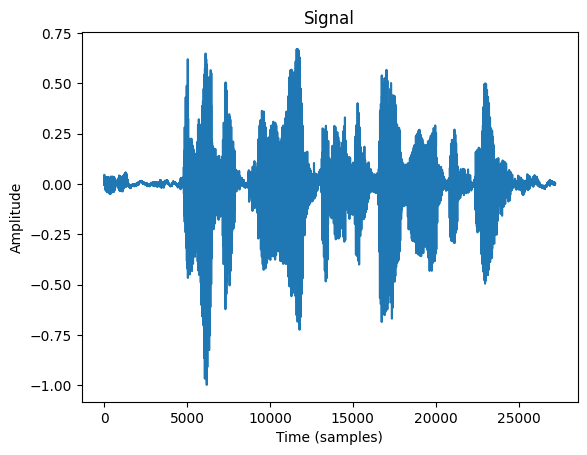

In [46]:
noisy = noiser(waveform)
show_and_play_signal(noisy, sample_rate)

In [29]:
from torchaudio_augmentations import RandomEncoder


encoder = RandomEncoder(
    sample_rate=8000,
)

encoded = encoder(waveform)
show_and_play_signal(encoded, sample_rate)